# Single Halo Bossting factor evaluation


For pessimistic model we adopt standard NFW \cite{1997ApJ...490..493N}. In the realistic and optimistic scenario stteper inner slope can increase boosting factor. Therefore we also use modified NFW profile can be written as:
\begin{equation}
\rho(r) = \dfrac{\rho_0}{(r/r_S)^\alpha(1+r/r_S)^{(3-\alpha)}},
\end{equation}
where an additional parameter \alpha emerges. For standard NFW $\alpha=1$.

The boosting factor can be evaluated analytically for this profile:
\begin{equation}
B(c) = \frac{c^3 \left(-\left(c^3 (-c)^{-2 \alpha} (c+1)^{2 \alpha-5} \left(2 \alpha^2-2 \alpha c-9 \alpha+c^2+5 c+10\right)\right)\right)}{\left(4 \alpha^3-24 \alpha^2+47 \alpha-30\right) \rm{B}_{-c}(3-\alpha,\alpha-2){}^2},
\end{equation}
where $\rm{B}$ is the incomplete beta function.



In [105]:
%matplotlib inline
from colossus.Cosmology import *
from colossus.HaloConcentration import *
from colossus.HaloDensityProfile import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betainc

setCosmology('planck13')
cosmo = getCurrent()

def NFWa(r,rs,rho0,alpha=1):
    '''
    Modified NFW profile (double power law). Used to describe profiles in the smallest halos (Ishiyama 2014)
    '''
    return rho0 * (r/rs)**-alpha * (1.0+r/rs)**(alpha-3.0)


def IshiyamaAlpha(M):
    '''
    Fitting function for alpha (parameter for modified NFW) from Ishiyama 2014:
    http://adsabs.harvard.edu/abs/2014ApJ...788...27I
    :param M: Virial mass of a halo in solar masses.
    :return: alpha (inner slope)
    '''
    alpha = -0.123*np.log10(M/1e-6)+1.461
    if isinstance(alpha, float):
        return np.max([1.0,alpha])
    else:
        alpha[alpha<1]=1.
        return alpha


Halo mass:  -7.0 ; Redshift:  30 ; Concentration:  2.99630267163 ; Inner slope (alpha):  1.584
Numerical  boosting factor:  1247770.58607
Analytical boosting factor (for alpha=1):  7.39853155347


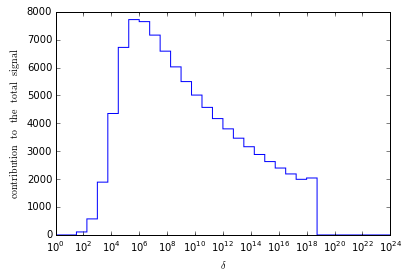

In [182]:
M = 1e-7# in Solar masses
z = 30   # redshift
c = concentration(M, 'vir', z, model='diemer15')
alpha = IshiyamaAlpha(M)

delta_list = np.logspace(0, 24, 33)
rho0, rs = profile.fundamentalParameters(M, c, z, 'vir')
V = 4./3.*np.pi*(c*rs)**3

def HaloBoost(z, M, c, alpha):
    '''
    Boosting factor of an individual halo
    z : redshift of the halo
    M : mass of the halo (in Msun)
    c : concentration
    alpha : inner slope
    '''
    profile = NFWProfile(M=M, mdef='vir', z=z, c=c)
    rho0, rs = profile.fundamentalParameters(M, c, z, 'vir')
    Rmax= c*rs
    R = np.logspace(np.log10(Rmax)-24, np.log10(Rmax), 100000)
    rhom = (AST_rho_crit_0_kpc3*cosmo.Om0*(1.+z)**3)
    rho = NFWa(R, rs, rho0, alpha=alpha)
    V = np.concatenate([[0], 4./3.*np.pi*R**3])
    V = np.diff(V)
    rho2V = rho**2*V
    B_nu = rho2V.sum() * V.sum() / M**2
    return B_nu

B_nu = HaloBoost(z, M, c, alpha)
B_an = rho0**2 / c**3  * V**2 / M**2

print 'Halo mass: ', np.log10(M), '; Redshift: ', z, '; Concentration: ', c, '; Inner slope (alpha): ', alpha
print 'Numerical  boosting factor: ', B_nu
print 'Analytical boosting factor (for alpha=1): ', B_an

plt.hist(rho/rhom, bins=delta_list, weights=rho2V, histtype='step')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\mathrm{contribution\;to\;the\;total\;signal}$')

## Average boosting factor for a halo of given mass with some scatter in concentration

In [181]:
def HaloBoost_c(z, M, c, alpha, cs):
    '''
    Boosting factor of an individual halo
    z : redshift of the halo
    M : mass of the halo (in Msun)
    c : concentration
    cs : concentration spread (in log10)
    alpha : inner slope    
    '''
    rand_c = 10**np.random.normal(np.log10(c), cs, 1000)
    temp = 0
    for i in range(len(rand_c)):
        temp += HaloBoost(z, M, rand_c[i], alpha)
    return temp / len(rand_c)

print HaloBoost_c(z, M, c, alpha, 0.2)
print HaloBoost(z, M, c, alpha)

304.738205679
241.369344404
